In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import plotly.express as px
drive.mount("/content/gdrive")  
!pwd  # show current path 

%cd "/content/gdrive/MyDrive/IA95022"
!ls  # show current directory

Mounted at /content/gdrive
/content
/content/gdrive/MyDrive/IA95022
 bezdekIris.data	      iris.data			 train.csv
 class_060922_starter.ipynb   iris.names		 us2022q2a.csv
 DryBeanDataset		      notebookdc8e90834b.ipynb	 usfirms2022.csv
 Index			     'Store Sales'		 Wine


In [3]:
# Carga de datos
usdata = pd.read_csv('us2022q2a.csv')
usfirms = pd.read_csv('usfirms2022.csv')
# Unimos la información de ambos datasets en un solo dataframe
usfirms.columns = usfirms.columns.str.replace('Ticker', 'firm')
df = pd.merge(usfirms, usdata, on="firm")

# Se obtienen los valores calculados 
df['lprice'] = df.groupby(['firm'])['adjprice'].shift(4)
df['r'] = np.log(df['adjprice']) - np.log(df['lprice'])
df['r2']= np.log(df['adjprice']) - np.log(df.groupby(['firm'])['adjprice'].shift(4))
df.loc['ADT': 'ADTN', ['adjprice', 'lprice', 'r', 'r2']].iloc[85:96,]
df['qdate'] = pd.PeriodIndex(df['q'], freq="Q")
df.set_index(['firm', 'qdate'], drop = True)
df.index
df.columns
df['lprice'] = df.groupby(['firm'])['adjprice'].shift(4)
df[['q', 'adjprice', 'lprice']]
df.loc['ADT': 'ADTN', ['adjprice', 'lprice']].iloc[84:98]

# Calculamos las variables para cada instancia de los datos
df['Book'] = df['totalassets'] - df['totalliabilities']
df['Market'] = df['originalprice'] * df['sharesoutstanding']
df["Ebit"] = df["revenue"] - df["cogs"] - df["sgae"] - df["otheropexp"]
df["OPM"] = df["Ebit"] / df["revenue"]
df["Net income"] = df["Ebit"] - df["incometax"] - df["finexp"]
df["Profit margin"] = df["Net income"] / df["revenue"]

In [4]:
df.columns

Index(['firm', 'Name', 'N', 'Class', 'Country\nof Origin', 'Type of Asset',
       'Sector NAICS\nlevel 1', 'Exchange / Src', 'Sector\nEconomatica',
       'Sector NAICS\nlast available', 'partind', 'q', 'revenue', 'cogs',
       'sgae', 'otheropexp', 'extraincome', 'finexp', 'incometax',
       'totalassets', 'totalliabilities', 'shortdebt', 'longdebt',
       'stockholderequity', 'adjprice', 'originalprice', 'sharesoutstanding',
       'fiscalmonth', 'year', 'cto', 'lprice', 'r', 'r2', 'qdate', 'Book',
       'Market', 'Ebit', 'OPM', 'Net income', 'Profit margin'],
      dtype='object')

# 2.2.2 About statistical modeling


## Financial services: Primer acercamiento

In [5]:
df.columns

Index(['firm', 'Name', 'N', 'Class', 'Country\nof Origin', 'Type of Asset',
       'Sector NAICS\nlevel 1', 'Exchange / Src', 'Sector\nEconomatica',
       'Sector NAICS\nlast available', 'partind', 'q', 'revenue', 'cogs',
       'sgae', 'otheropexp', 'extraincome', 'finexp', 'incometax',
       'totalassets', 'totalliabilities', 'shortdebt', 'longdebt',
       'stockholderequity', 'adjprice', 'originalprice', 'sharesoutstanding',
       'fiscalmonth', 'year', 'cto', 'lprice', 'r', 'r2', 'qdate', 'Book',
       'Market', 'Ebit', 'OPM', 'Net income', 'Profit margin'],
      dtype='object')

En la siguiente gráfica podemos ver un panorama general de cómo ha variado históricamente el valor de libro de cada empresa del sector.

In [6]:
rslt_df = df.loc[df['Sector\nEconomatica'] == 'Finance and Insurance'] 

px.line(rslt_df, x = 'q', y = 'Book', color = "firm", title="Gráfica de book value histórico de cada firma de Finance and Insurance")


## Using your subset of firms that belong to your industry, which factors (variables) might be related to annual stock return one quarter in the future? Select at least 3 factors and briefly explain why you think might be related to stock returns.



A continuación, graficaremos cómo se relacionan las distintas variables con el fin de buscar alguna que pueda tener correlación con el stock return que se tiene

In [7]:
# Seleccionamos solo los valores que nos serán de utilidad en este análisis
df_analysis = rslt_df[['firm','q','r', 'r2', 'cogs', 'sgae', 'otheropexp', 'revenue', 'Ebit','OPM', 'Book', 'Market', 'Profit margin']]

# Calculamos las nuevas variables 

df_analysis["OPM"] = df["Ebit"] / df["revenue"]
df_analysis['BookToMarketRatio'] = df['Book'] / df['Market']
df_analysis['ShortFinancialLeverage'] = df["shortdebt"] / df["totalassets"] 
df_analysis['LongFinancialLeverage'] = df["longdebt"] / df["totalassets"] 
df_analysis['OperatingProfitGrowth'] = (df["Ebit"] - df["Ebit"].shift(4)) - 1
df_analysis['SalesAnnualGrowth'] = (df["revenue"] / df["revenue"].shift(4)) - 1 
df_analysis['EPS'] = df["Net income"] / df["sharesoutstanding"]
df_analysis["lprice"] = df["lprice"]
df_analysis['EPSP'] =  df_analysis["EPS"] / df_analysis["lprice"]
df_analysis['Size'] =  df["Market"] 
df_analysis["small?"] = df_analysis.Size <= df_analysis.Size.quantile(.33) 
df_analysis["small?"] = df_analysis["small?"].astype(int)
df_analysis["medium?"] = (df_analysis.Size <= df_analysis.Size.quantile(.66)) & (df_analysis.Size > df_analysis.Size.quantile(.33)) 
df_analysis["medium?"] = df_analysis["medium?"].astype(int)

#msg = "Even" if to_check%2 == 0 else "Odd"
df_analysis  = df_analysis.replace([np.inf, -np.inf], np.nan).dropna()

#df_30per = df_analysis[df.Book < df.Book.quantile(.30)]

#q2_2022 = df_analysis['q']=='2022q2' 
#df_analysis = df_analysis[q2_2022]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f363ed2d550>,
      dtype=object)

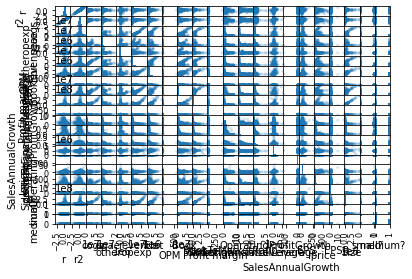

In [8]:
pd.plotting.scatter_matrix(df_analysis, alpha=0.2)

Vemos que es difícil encontrar alguna variable que parezca tener una correlación. Para verlo numéricamente, imprimiremos los valores de la correlación de pearson

In [9]:
df_analysis.corr(method="pearson")

,r,r2,cogs,sgae,otheropexp,revenue,Ebit,OPM,Book,Market,...,ShortFinancialLeverage,LongFinancialLeverage,OperatingProfitGrowth,SalesAnnualGrowth,EPS,lprice,EPSP,Size,small?,medium?
r,1.000000,1.000000,0.035624,0.017103,0.015348,0.040685,0.080893,0.006865,0.044974,0.070537,...,-0.015322,-0.050141,0.145928,-0.038503,0.177292,-0.075319,0.136442,0.070537,-0.143006,-0.009466
r2,1.000000,1.000000,0.035624,0.017103,0.015348,0.040685,0.080893,0.006865,0.044974,0.070537,...,-0.015322,-0.050141,0.145928,-0.038503,0.177292,-0.075319,0.136442,0.070537,-0.143006,-0.009466
cogs,0.035624,0.035624,1.000000,0.271157,0.189767,0.979168,0.819192,-0.007616,0.732029,0.821566,...,-0.031311,0.022687,0.179366,0.003048,0.158204,0.260531,-0.011705,0.821566,-0.105518,-0.146683
sgae,0.017103,0.017103,0.271157,1.000000,0.095636,0.454816,0.315852,-0.011042,0.378493,0.251119,...,-0.036403,-0.000486,0.051481,0.004245,0.107568,0.140591,-0.013134,0.251119,-0.133278,-0.146309
otheropexp,0.015348,0.015348,0.189767,0.095636,1.000000,0.217189,0.126396,-0.002229,0.154053,0.091172,...,0.001168,0.009711,0.099390,-0.000434,0.013964,0.008578,-0.002557,0.091172,-0.048880,-0.051877
revenue,0.040685,0.040685,0.979168,0.454816,0.217189,1.000000,0.845907,-0.009373,0.771370,0.826888,...,-0.037450,0.019604,0.199482,0.003073,0.182913,0.277233,-0.012029,0.826888,-0.132398,-0.173707
Ebit,0.080893,0.080893,0.819192,0.315852,0.126396,0.845907,1.000000,-0.008049,0.838846,0.905919,...,-0.044844,0.000348,0.417469,-0.004418,0.327655,0.333073,0.007731,0.905919,-0.185603,-0.228873
OPM,0.006865,0.006865,-0.007616,-0.011042,-0.002229,-0.009373,-0.008049,1.000000,-0.006270,-0.004427,...,-0.007021,0.021575,-0.007592,-0.000792,-0.032512,-0.005810,-0.016773,-0.004427,-0.007189,0.018062
Book,0.044974,0.044974,0.732029,0.378493,0.154053,0.771370,0.838846,-0.006270,1.000000,0.838623,...,-0.080906,-0.023416,0.187609,0.006476,0.283663,0.366738,-0.009420,0.838623,-0.233032,-0.288879
Market,0.070537,0.070537,0.821566,0.251119,0.091172,0.826888,0.905919,-0.004427,0.838623,1.000000,...,-0.056967,-0.011186,0.227968,0.005593,0.247567,0.393918,-0.015057,1.000000,-0.179795,-0.226306


Vemos que los valores de correlación son bastante bajos. Algo interesante a notar es que en la gráfica que hicimos al inicio se observa la presencia de muchos valores agrupados en un extremo, por lo que contamos con la presencia de valores extremos en nuestro modelo.

Con fines de modelación, vamos  a remover estos valores extremos, para concentrarnos en analizar los casos más comunes del mercado, dejando fuera a aquellos casos excepcionales de éxito.


Comenzaremos viendo la descripción matemática de cada columna, para darnos una idea de los valores que se manejan en cada una.

In [10]:
df_analysis.describe()

,r,r2,cogs,sgae,otheropexp,revenue,Ebit,OPM,Book,Market,...,ShortFinancialLeverage,LongFinancialLeverage,OperatingProfitGrowth,SalesAnnualGrowth,EPS,lprice,EPSP,Size,small?,medium?
count,4164.000000,4164.000000,4.164000e+03,4.164000e+03,4.164000e+03,4.164000e+03,4.164000e+03,4164.000000,4.164000e+03,4.164000e+03,...,4164.000000,4164.000000,4.164000e+03,4164.000000,4164.000000,4164.000000,4164.000000,4.164000e+03,4164.000000,4164.000000
mean,0.109426,0.109426,1.208548e+06,5.377981e+05,1.909607e+04,1.972261e+06,2.068185e+05,0.393564,4.001875e+06,9.786261e+06,...,0.044850,0.166434,2.172298e+04,-0.509303,1.010037,49.936779,0.037363,9.786261e+06,0.199087,0.343420
std,0.406805,0.406805,5.689980e+06,1.296367e+06,1.729397e+05,6.647535e+06,5.306934e+05,9.140698,8.200407e+06,2.660751e+07,...,0.115710,0.210637,2.323562e+05,45.192589,2.016186,76.861410,0.299403,2.660751e+07,0.399362,0.474907
min,-2.931138,-2.931138,-1.213960e+05,-7.550000e+05,-1.389770e+06,-1.469086e+06,-1.140652e+06,-5.522598,-3.764790e+05,4.139077e+03,...,0.000000,0.000000,-3.263001e+06,-2914.393204,-13.422694,0.391500,-1.572562,4.139077e+03,0.000000,0.000000
25%,-0.098018,-0.098018,0.000000e+00,4.152850e+04,0.000000e+00,8.346450e+04,1.116125e+04,0.078722,2.548885e+05,6.562457e+05,...,0.000000,0.000000,-4.436750e+03,-0.017884,0.203325,13.034665,0.008464,6.562457e+05,0.000000,0.000000
50%,0.133476,0.133476,0.000000e+00,1.372160e+05,0.000000e+00,2.436805e+05,5.155250e+04,0.237213,8.271525e+05,2.517322e+06,...,0.001449,0.104301,3.771500e+03,0.096489,0.553472,25.224389,0.020289,2.517322e+06,0.000000,0.000000
75%,0.331890,0.331890,0.000000e+00,3.879250e+05,0.000000e+00,8.215170e+05,1.750382e+05,0.393534,3.749191e+06,7.945755e+06,...,0.028348,0.227955,2.785775e+04,0.232470,1.190598,52.779698,0.038057,7.945755e+06,0.000000,1.000000
max,1.984389,1.984389,7.320000e+07,2.031020e+07,3.491000e+06,8.033200e+07,9.241000e+06,588.077670,7.620500e+07,4.818731e+08,...,0.777014,2.972546,5.688652e+06,72.600000,50.837204,855.309271,16.504122,4.818731e+08,1.000000,1.000000


In [11]:
px.histogram(df_analysis['Book'])

Vemos que los datos se encuentran altamente agrupados a la izquierda, esto es porque hay valores muy extremos que rompen con lo "normal". 

La mayoría de los datos se encuentran por debajo del 25 percentil (aproximadamente). Así que vamos a tomar como base el 30 percentil, para dar un ligero margen a nuestra aproximación de 25.

In [12]:
df_30per = df_analysis[df.Book < df.Book.quantile(.30)]
print(df_30per.describe())
print('\n')
print(df_30per.median())

                r          r2           cogs           sgae    otheropexp  \
count  876.000000  876.000000     876.000000     876.000000    876.000000   
mean     0.087848    0.087848    7458.969682   23757.076632   1346.129612   
std      0.502181    0.502181   24564.719858   36984.701792   5821.184408   
min     -1.689317   -1.689317       0.000000    -189.595990  -3997.000000   
25%     -0.217552   -0.217552       0.000000    2139.416750      0.000000   
50%      0.073802    0.073802       0.000000   12399.500000      0.000000   
75%      0.384472    0.384472       0.000000   26387.750000      0.000000   
max      1.984389    1.984389  155017.000000  330277.000000  53015.000000   

             revenue           Ebit         OPM           Book        Market  \
count     876.000000     876.000000  876.000000     876.000000  8.760000e+02   
mean    42505.830935    9943.655010    0.313663   60934.606502  4.915135e+05   
std     53766.883113   22452.088809    1.061117   68508.831825  7.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [13]:
df_30per.corr(method="pearson")

,r,r2,cogs,sgae,otheropexp,revenue,Ebit,OPM,Book,Market,...,ShortFinancialLeverage,LongFinancialLeverage,OperatingProfitGrowth,SalesAnnualGrowth,EPS,lprice,EPSP,Size,small?,medium?
r,1.000000,1.000000,-0.029602,-0.123023,-0.113777,-0.099599,0.026027,-0.000116,0.093382,0.138983,...,-0.006814,-0.084249,0.145874,0.441160,0.177842,-0.008453,0.183392,0.138983,-0.116598,0.090349
r2,1.000000,1.000000,-0.029602,-0.123023,-0.113777,-0.099599,0.026027,-0.000116,0.093382,0.138983,...,-0.006814,-0.084249,0.145874,0.441160,0.177842,-0.008453,0.183392,0.138983,-0.116598,0.090349
cogs,-0.029602,-0.029602,1.000000,-0.031507,0.392077,0.470195,-0.017855,-0.074330,0.220327,0.068390,...,-0.063057,0.132820,-0.048914,0.006618,-0.035754,0.032952,-0.019069,0.068390,-0.233247,0.253619
sgae,-0.123023,-0.123023,-0.031507,1.000000,0.010089,0.756780,0.196873,-0.088730,0.021760,0.481860,...,0.074020,0.244287,-0.146642,-0.066334,0.001570,0.104674,0.006055,0.481860,-0.446882,0.393958
otheropexp,-0.113777,-0.113777,0.392077,0.010089,1.000000,0.318477,0.057809,-0.048292,0.182024,-0.064818,...,0.014127,0.306541,-0.110970,-0.048510,-0.042764,-0.062863,-0.014923,-0.064818,0.067023,-0.059061
revenue,-0.099599,-0.099599,0.470195,0.756780,0.318477,1.000000,0.551107,-0.059466,0.232522,0.513698,...,0.112621,0.351406,0.072279,-0.005352,0.097254,0.130648,0.054010,0.513698,-0.525534,0.471569
Ebit,0.026027,0.026027,-0.017855,0.196873,0.057809,0.551107,1.000000,0.097601,0.232733,0.378398,...,0.213095,0.214322,0.496938,0.101791,0.280518,0.120687,0.144097,0.378398,-0.284562,0.218159
OPM,-0.000116,-0.000116,-0.074330,-0.088730,-0.048292,-0.059466,0.097601,1.000000,0.003928,0.013995,...,0.035338,-0.023991,-0.021559,-0.011821,-0.089902,0.067891,0.007858,0.013995,-0.007007,0.004367
Book,0.093382,0.093382,0.220327,0.021760,0.182024,0.232522,0.232733,0.003928,1.000000,0.080574,...,0.188308,-0.268309,0.072347,0.034538,0.094046,0.052013,0.062646,0.080574,-0.094976,0.090803
Market,0.138983,0.138983,0.068390,0.481860,-0.064818,0.513698,0.378398,0.013995,0.080574,1.000000,...,0.072087,0.189072,0.108974,0.088238,0.057567,0.535480,-0.033244,1.000000,-0.698764,0.492270


In [14]:
px.histogram(df_30per['Book'])

Ahora que hicimos "zoom" a una parte de nuestro dataset que es más representativa de los casos comunes de empresas de Finanzas e inversiones en el mercado, podemos ver que existen variables que se correlacionan en cierta medida con el retorno de la acción, como lo son el Operating profit margin, el Sales Annual Growth y el Long Finance Leverage.

A continuación daremos un recorrido descriptivo a través de estas variables.

### OPM

In [15]:
px.histogram(df_analysis['OPM'])

Para el OPM, podemos ver una distribución casi normal en nuestra muestra. 
Los valores oscilan de 0 a 1 porque esta métrica nos da un porcentaje de cuál fue el margen de ganancias operativas para cada firma. 

Esta variable puede estar relacionada directamente con el retorno porque directamente representa una ganancia para la firma. Sin embargo, obtener retornos de una acción no solo dependerá de si la empresa tiene un buen margen de ganancias o no, por lo tanto es importante contemplar más variables en nuestro modelo.

In [16]:
df_analysis["OPM"].describe()

count    4164.000000
mean        0.393564
std         9.140698
min        -5.522598
25%         0.078722
50%         0.237213
75%         0.393534
max       588.077670
Name: OPM, dtype: float64

In [17]:
px.scatter(df_analysis, x = 'r', y = 'OPM', color = 'firm', title = "Return vs OPM (Q2 2022)")

Con la gráfica de return vs OPM podemos complementar visualmente lo dicho, ya que Se observa claramente que el OPM tiende a ser mayor conforme el retorno es más grande.

### Sales Annual Growth

In [18]:
px.histogram(df_analysis['SalesAnnualGrowth'])

Para el Sales Annual Growth notamos que aún tenemos los datos agrupados a la izquierda, pero es en una medida mucho menor a la que observamos antes de filtrar los datos. 

Esta métrica nos permite saber qué tanto crecieron las ventas de una firma durante el año en cuestión.


In [19]:
df_analysis["SalesAnnualGrowth"].describe()

count    4164.000000
mean       -0.509303
std        45.192589
min     -2914.393204
25%        -0.017884
50%         0.096489
75%         0.232470
max        72.600000
Name: SalesAnnualGrowth, dtype: float64

In [20]:
px.scatter(df_analysis, x = 'r', y = 'SalesAnnualGrowth', color = 'firm', title = "Return vs Sales Annual Growth (Q2 2022)")

En este caso observamos también una tendencia positiva, sin embargo esta se presenta de una forma más sutl en la mayoría de los datos presentes. 

### Long Financial Leverage	

In [21]:
px.histogram(df_analysis['LongFinancialLeverage'])

Para el long financial leverage observamos que tenemos un tailoring evidente, con la mayoría de los datos cargados a la izquierda. Una vez más, este tailoring se vio reducido drásticamente por el filtrado de datos que se hizo inicialmente, ya que de lo contrario sería mucho más alta la diferencia entre los valores extremos y la mayoría de los valores.

Sabemos que el financial leverage es como tal un préstamo que tiene la firma para potenciar su crecimiento, por lo que al ser un préstamo suele traducirse al pago de intereses y a posibles pérdidas si el proyecto no tiene el impacto esperado. Utilizar capital ajeno siempre representa un riesgo mayor, ya que el límite de perdidas no es solo el total del capital, si no que es el total del capital más la deuda generada en intereses por el capital.

In [22]:
df_analysis["LongFinancialLeverage"].describe()

count    4164.000000
mean        0.166434
std         0.210637
min         0.000000
25%         0.000000
50%         0.104301
75%         0.227955
max         2.972546
Name: LongFinancialLeverage, dtype: float64

In [23]:
px.scatter(df_analysis, x = 'r', y = 'LongFinancialLeverage', color = 'firm', title = "Return vs LongFinancialLeverage (Q2 2022")

Notamos que hay una tendencia negativa bastante evidente en algunos datos. Curiosamente, también notamos una serie de datos que parecen ignorar esta tendencia y mostrar un comportamiento lineal.
Sabemos 

## Design and run a multiple regression model to examine whether your selected factors and earnings per share deflated by price can explain/predict annual stock returns. You have to control for industry and firm size. To control for these variables you have to include them as extra independent variables in the model

### Iniciamos la creación del modelo
Utilizaremos la librería de aprendizaje sklearn 


## Interpret your model



In [24]:
import statsmodels.api as sm


#add constant to predictor variables
X = df_analysis[["EPSP","OPM", "SalesAnnualGrowth", "LongFinancialLeverage", "small?", "medium?"]]
x = sm.add_constant(X)
y = df_analysis["r2"]
#fit linear regression model
#model = sm.OLS(y_train, X_train).fit(start_params=[-5.64482139e-06, -5.86149020e-05,  4.37488837e-06], maxiter=0)
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())



#model = model.fit(start_params=[-5.64482139e-06, -5.86149020e-05,  4.37488837e-06], maxiter=0)


                            OLS Regression Results                            
Dep. Variable:                     r2   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     35.90
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.32e-42
Time:                        14:40:19   Log-Likelihood:                -2057.6
No. Observations:                4164   AIC:                             4129.
Df Residuals:                    4157   BIC:                             4173.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.17

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Adjustments to your model. If there is one or more independent variables (factors or control variables) that were not significant, drop them from your model. You have to run and interpret your final model.